# 데이터 웹 크롤링

In [1]:
from bs4 import BeautifulSoup
import urllib.request as req # url 호출 라이브러리 

In [5]:
url = "https://www.weforum.org/agenda/archive/fourth-industrial-revolution?page=%s"

rpTitle=[] # 제목 리스트 추출
for i in list(range(1,213)):
    url_list = url % (i)
    html = req.urlopen(url_list)
    bsObject = BeautifulSoup(html,"html.parser")
    res_list = bsObject.find_all("h3", class_="tout__title")
    for link in res_list: 
        res_list = link.get_text()
        rpTitle.append(res_list)

In [6]:
rpTitle[0:5]

['\n              Fourth Industrial Revolution\n            ',
 'COVID-19: Emerging technologies are now critical infrastructure – what that means for governance',
 'How China’s industrial internet is fighting COVID-19',
 'How personal data could help contribute to a COVID-19 solution',
 'Coronavirus: seven ways collective intelligence is tackling the pandemic']

In [8]:
rpDescription=[] # 요약 리스트 추출
for i in list(range(1,213)):
    url_list = url % (i)
    html = req.urlopen(url_list)
    bsObject = BeautifulSoup(html,"html.parser")
    res_list = bsObject.find_all("p", class_="tout__description")
    for link in res_list: 
        res_list = link.get_text()
        rpDescription.append(res_list)

In [7]:
rpDescription[0:5]

['\n              Explore the latest strategic trends, research and analysis\n            ',
 "The industrial internet, focusing primarily on business and industry, has worked to protect society’s normal operation during China's COVID-19 outbreak.",
 'Companies are turning to technology to fight the COVID-19 pandemic.',
 'Digital technology is allowing people to come together and generate important new insights on the coronavirus outbreak.',
 'The World Economic Forum announces its Young Global Leaders class of 2020 - influential people from around the world who committed to making the world a better place.']

In [7]:
rpCaption=[] # 날짜 리스트 추출 
for i in list(range(1,213)):
    url_list = url % (i)
    html = req.urlopen(url_list)
    bsObject = BeautifulSoup(html,"html.parser")
    res_list = bsObject.find_all("div", class_="caption")
    for link in res_list: 
        res_list = link.get_text()
        rpCaption.append(res_list)

In [9]:
# " report -  "제거 
import re
for i in range(len(rpCaption)):
    rpCaption[i]=re.sub("Report| — ","",rpCaption[i])


In [10]:
rpCaption[0]

'Fourth Industrial Revolution'

# 데이터 프레임 생성

In [11]:
import pandas as pd 

In [12]:
WEFdata=pd.DataFrame(rpCaption,columns=['date'])
WEFdata['title']=pd.DataFrame(rpTitle,columns=['title'])
WEFdata['summary']=pd.DataFrame(rpDescription,columns=['summary'])

In [13]:
WEFdata.to_csv("WEFdata2.csv") # 원데이터 생성 

In [15]:
WEFdata=WEFdata[WEFdata.isnull()==False]

In [19]:
WEFdata.dropna()

,date,title,summary
0,Fourth Industrial Revolution,\n Fourth Industrial Revolution\n...,\n Explore the latest strategic t...
1,Kimmy Bettinger 10 Apr 2020,COVID-19: Emerging technologies are now critic...,Tech tools have become essential infrastructur...
2,COVID-19,How China’s industrial internet is fighting CO...,"The industrial internet, focusing primarily on..."
3,Lau Sengyee 08 Apr 2020,How personal data could help contribute to a C...,Companies are turning to technology to fight t...
4,COVID-19,Coronavirus: seven ways collective intelligenc...,Digital technology is allowing people to come ...
...,...,...,...
3387,Brian Bilston 11 Jul 2016,The tech breakthrough that will fight climate ...,
3388,Fourth Industrial Revolution,You’re already building the future of big data,
3389,Adrian Monck 08 Jul 2016,14 tech predictions for our world in 2020,
3390,Fourth Industrial Revolution,3 steps to get more women into tech,


In [20]:
WEFdata['document']=WEFdata['title']+WEFdata['summary']
WEFdf=pd.DataFrame({'document':WEFdata['document']})
WEFdf=WEFdf.dropna() # 토픽모델링할 데이터 생성 

In [21]:
# 특수문자 제거
WEFdf['clean_doc']=WEFdf['document'].str.replace("[^a-zA-Z]"," ")
WEFdf.tail()

,document,clean_doc
3387,The tech breakthrough that will fight climate ...,The tech breakthrough that will fight climate ...
3388,You’re already building the future of big data,You re already building the future of big data
3389,14 tech predictions for our world in 2020,tech predictions for our world in
3390,3 steps to get more women into tech,steps to get more women into tech
3391,Google: from the garage to the moon,Google from the garage to the moon


In [22]:
# 3글자 이하 제거 
WEFdf['clean_doc'] = WEFdf['clean_doc'].apply(lambda x:" ".join([w for w in x.split() if len(w)>3]))

In [23]:
# 소문자 변환 
WEFdf['clean_doc'] = WEFdf['clean_doc'].apply(lambda x:x.lower())

In [24]:
# 불용어 제거 
from nltk.corpus import stopwords
stopword = stopwords.words('english')

tokenizedDoc = WEFdf['clean_doc'].apply(lambda x:x.split())
tokenizedDoc = tokenizedDoc.apply(lambda x : [item for item in x if item not in stopword])

In [74]:
tokenizedDoc[0]

['fourth',
 'industrial',
 'revolution',
 'explore',
 'latest',
 'strategic',
 'trends',
 'research',
 'analysis']

# TF-IDF 매트릭스 구성

In [36]:
# 역 토큰화 
deTokenizedDoc = []
for i in range(len(WEFdf)):
    temp = " ".join(tokenizedDoc[i])
    deTokenizedDoc.append(temp)

WEFdf['clean_doc'] = deTokenizedDoc

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
vector = TfidfVectorizer(stop_words="english")
res = vector.fit_transform(WEFdf['clean_doc'])
res.shape

(3392, 8576)

In [43]:
from sklearn.decomposition import TruncatedSVD
svdModel = TruncatedSVD(n_components=20)
svdModel.fit(res)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
             random_state=None, tol=0.0)

In [44]:
import numpy as np
np.shape(svdModel.components_)

(20, 8576)

In [45]:
terms=vector.get_feature_names()

# 토픽 추출

In [46]:
def getTopic(model, fName, n=10):
    for i , t in enumerate(model):
        print("토픽: %d" %(i+1), [(fName[i],t[i].round(5)) 
                                for i in t.argsort()[:-n-1:-1]])


In [62]:
getTopic(svdModel.components_,terms) # 주제추출이 어렵군.. 

토픽: 1 [('strategic', 0.34933), ('analysis', 0.34925), ('explore', 0.34703), ('latest', 0.34649), ('trends', 0.34011), ('research', 0.3235), ('fourth', 0.31535), ('industrial', 0.3126), ('revolution', 0.3123), ('future', 0.00499)]
토픽: 2 [('stories', 0.36594), ('technology', 0.31222), ('read', 0.2917), ('weekend', 0.24396), ('future', 0.22072), ('world', 0.20673), ('change', 0.18864), ('digital', 0.15221), ('data', 0.13153), ('internet', 0.12293)]
토픽: 3 [('stories', 0.52337), ('read', 0.45676), ('weekend', 0.41703), ('week', 0.11763), ('days', 0.0551), ('science', 0.05063), ('seven', 0.05034), ('round', 0.04743), ('strategic', 0.03587), ('analysis', 0.03568)]
토픽: 4 [('internet', 0.51693), ('things', 0.25989), ('data', 0.23234), ('future', 0.1114), ('world', 0.09081), ('industrial', 0.08674), ('robots', 0.06735), ('revolution', 0.05912), ('fourth', 0.05314), ('need', 0.04891)]
토픽: 5 [('data', 0.59842), ('robots', 0.10752), ('revolution', 0.09749), ('help', 0.09115), ('world', 0.08728), ('

# 워드클라우드 생성

In [48]:
# vectorizer 내에서 높은 순위로 고려되는 단어들을 불러오는 함수를 생성 
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0) # 문서마다 단어의 tfidf 합산
    data = []
    for col, term in enumerate(terms): 
        data.append( (term, sums[0,col])) # 단어의 tfidf 값 매핑하여 리스트에 추가
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank',ascending=False) 
    # tfidf 내림차순으로 정렬하여 데이터프레임 생성  
    return ranked 

ranked = rank_words(terms=vector.get_feature_names(), feature_matrix=res)


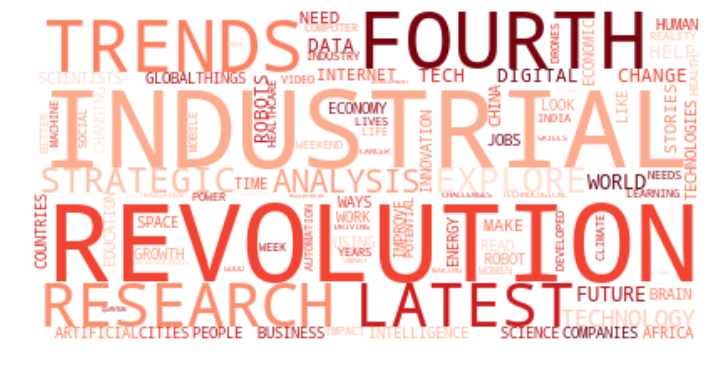

In [51]:
import matplotlib.pyplot as plt
# 워드클라우드로 idf 역행렬로 얻어진 단어들의 빈도수를 시각화 
dic = {ranked.loc[i,'term'].upper() : ranked.loc[i,'rank']
      for i in range(0,len(ranked))}

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",
                     max_words=100,
                     colormap="Reds").generate_from_frequencies(dic)

fig = plt.figure(1, figsize=(12,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

fourth-industrial-revolution 은 전체주제이기 때문에 데이터 전처리과정에서 제거하고 다시 분석해보자. 

In [148]:
pd.read_csv("WEFdata2.csv")

,Unnamed: 0,date,title,summary
0,0,Fourth Industrial Revolution,\n Fourth Industrial Revolution\n...,\n Explore the latest strategic t...
1,1,Kimmy Bettinger 10 Apr 2020,COVID-19: Emerging technologies are now critic...,Tech tools have become essential infrastructur...
2,2,COVID-19,How China’s industrial internet is fighting CO...,"The industrial internet, focusing primarily on..."
3,3,Lau Sengyee 08 Apr 2020,How personal data could help contribute to a C...,Companies are turning to technology to fight t...
4,4,COVID-19,Coronavirus: seven ways collective intelligenc...,Digital technology is allowing people to come ...
...,...,...,...,...
6355,6355,Fulvia Montresor 26 Aug 2014,NaN,NaN
6356,6356,Fourth Industrial Revolution,NaN,NaN
6357,6357,Ryan Holmes 25 Aug 2014,NaN,NaN
6358,6358,Fourth Industrial Revolution,NaN,NaN


In [149]:
WEFdata.dropna()

,date,title,summary,document
0,Fourth Industrial Revolution,\n Fourth Industrial Revolution\n...,\n Explore the latest strategic t...,\n Fourth Industrial Revolution\n...
1,Kimmy Bettinger 10 Apr 2020,COVID-19: Emerging technologies are now critic...,Tech tools have become essential infrastructur...,COVID-19: Emerging technologies are now critic...
2,COVID-19,How China’s industrial internet is fighting CO...,"The industrial internet, focusing primarily on...",How China’s industrial internet is fighting CO...
3,Lau Sengyee 08 Apr 2020,How personal data could help contribute to a C...,Companies are turning to technology to fight t...,How personal data could help contribute to a C...
4,COVID-19,Coronavirus: seven ways collective intelligenc...,Digital technology is allowing people to come ...,Coronavirus: seven ways collective intelligenc...
...,...,...,...,...
3387,Brian Bilston 11 Jul 2016,The tech breakthrough that will fight climate ...,,The tech breakthrough that will fight climate ...
3388,Fourth Industrial Revolution,You’re already building the future of big data,,You’re already building the future of big data
3389,Adrian Monck 08 Jul 2016,14 tech predictions for our world in 2020,,14 tech predictions for our world in 2020
3390,Fourth Industrial Revolution,3 steps to get more women into tech,,3 steps to get more women into tech


In [150]:
WEFdata['document']=WEFdata['title']+WEFdata['summary']
WEFdf=pd.DataFrame({'document':WEFdata['document']})
WEFdf=WEFdf.dropna() # 토픽모델링할 데이터 생성 

In [152]:
# 특수문자 제거
WEFdf['clean_doc']=WEFdf['document'].str.replace("[^a-zA-Z]"," ")
WEFdf.tail()

,document,clean_doc
3387,The tech breakthrough that will fight climate ...,The tech breakthrough that will fight climate ...
3388,You’re already building the future of big data,You re already building the future of big data
3389,14 tech predictions for our world in 2020,tech predictions for our world in
3390,3 steps to get more women into tech,steps to get more women into tech
3391,Google: from the garage to the moon,Google from the garage to the moon


In [153]:
# 소문자 변환 
WEFdf['clean_doc'] = WEFdf['clean_doc'].apply(lambda x:x.lower())

In [154]:
# 불용어 제거 
from nltk.corpus import stopwords
stopword = stopwords.words('english')

tokenizedDoc = WEFdf['clean_doc'].apply(lambda x:x.split())
tokenizedDoc = tokenizedDoc.apply(lambda x : [item for item in x if item not in stopword])

# 사전 정의 단어 제거 
word =  ['fourth','industrial','revolution']
tokenizedDoc = tokenizedDoc.apply(lambda x : [item for item in x if item not in word])

In [155]:
# 역 토큰화 
deTokenizedDoc = []
for i in range(len(WEFdf)):
    temp = " ".join(tokenizedDoc[i])
    deTokenizedDoc.append(temp)

WEFdf['clean_doc'] = deTokenizedDoc

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
vector = TfidfVectorizer(stop_words="english")
res = vector.fit_transform(WEFdf['clean_doc'])
res.shape

(3392, 8884)

In [157]:
from sklearn.decomposition import TruncatedSVD
svdModel = TruncatedSVD(n_components=20)
svdModel.fit(res)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
             random_state=None, tol=0.0)

In [158]:
import numpy as np
np.shape(svdModel.components_)

(20, 8884)

In [159]:
terms=vector.get_feature_names()

In [160]:
def getTopic(model, fName, n=10):
    for i , t in enumerate(model):
        print("토픽: %d" %(i+1), [(fName[i],t[i].round(5)) 
                                for i in t.argsort()[:-n-1:-1]])


In [161]:
getTopic(svdModel.components_,terms)

토픽: 1 [('strategic', 0.41618), ('analysis', 0.41616), ('explore', 0.41337), ('latest', 0.41268), ('trends', 0.40489), ('research', 0.38529), ('future', 0.00244), ('shaping', 0.0019), ('tech', 0.00124), ('technology', 0.00115)]
토픽: 2 [('stories', 0.33185), ('technology', 0.29988), ('read', 0.26628), ('weekend', 0.22117), ('future', 0.21906), ('world', 0.20733), ('new', 0.17629), ('change', 0.17128), ('data', 0.14983), ('digital', 0.14612)]
토픽: 3 [('stories', 0.54187), ('read', 0.4748), ('weekend', 0.43597), ('week', 0.11857), ('days', 0.05628), ('seven', 0.05256), ('science', 0.05079), ('round', 0.0487), ('weeka', 0.0362), ('weekly', 0.03468)]
토픽: 4 [('data', 0.75427), ('big', 0.51299), ('trust', 0.05391), ('improve', 0.05371), ('world', 0.04865), ('internet', 0.03809), ('minutes', 0.0339), ('open', 0.03171), ('development', 0.03148), ('explained', 0.03146)]
토픽: 5 [('internet', 0.71807), ('things', 0.35035), ('future', 0.18748), ('world', 0.04398), ('ready', 0.04272), ('change', 0.04229

In [162]:
# vectorizer 내에서 높은 순위로 고려되는 단어들을 불러오는 함수를 생성 
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0) # 문서마다 단어의 tfidf 합산
    data = []
    for col, term in enumerate(terms): 
        data.append( (term, sums[0,col])) # 단어의 tfidf 값 매핑하여 리스트에 추가
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank',ascending=False) 
    # tfidf 내림차순으로 정렬하여 데이터프레임 생성  
    return ranked 

ranked = rank_words(terms=vector.get_feature_names(), feature_matrix=res)

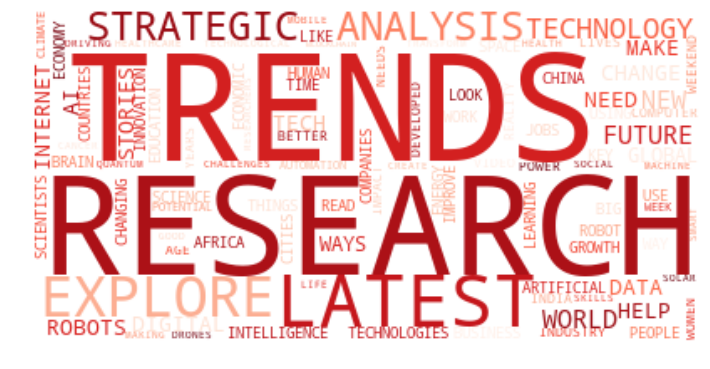

In [163]:
import matplotlib.pyplot as plt
# 워드클라우드로 idf 역행렬로 얻어진 단어들의 빈도수를 시각화 
dic = {ranked.loc[i,'term'].upper() : ranked.loc[i,'rank']
      for i in range(0,len(ranked))}

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",
                     max_words=100,
                     colormap="Reds").generate_from_frequencies(dic)

fig = plt.figure(1, figsize=(12,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()